In [1]:
using BlossomV, LinearAlgebra, SparseArrays

In [2]:
# Implements algorithm 1 in Improved Algorithms for Detecting Negative Cost Cycles in Undirected Graphs.
# Xiaofeng Gu1, Kamesh Madduri, K. Subramani and Hong-Jian Lai

function optimal_cycle(G)
    G = sparse(G)
    @assert issymmetric(G)
    rows, weights  = rowvals(G), nonzeros(G)
    ∂(i) = zip((@view rows[nzrange(G,i)]), (@view weights[nzrange(G,i)]))
    edge(i,j,w) = add_edge(E, i-1, j-1, w)
    match(i) = get_match(E, i - 1) + 1
    n = size(G,1);
    m = Int(length(rows)/2)
    E = Matching(Float64, 2n+2m)
    D = Tuple{Int,Int}[]
    k = 2n+1
    for i=1:n
        edge(i, i+n, 0)
        for (j,w) in ∂(i)
            if i < j
                edge(i,     k,   w)
                edge(i + n, k,   w)
                edge(j,     k+1, w)
                edge(j + n, k+1, w)
                edge(k,     k+1, 0)
                push!(D, (i,j))
                k+=2
            end
        end
    end
    @assert k == 2n+2m+1

    solve(E)

    cycle = [D[k] for k=1:m if match(2k + 2n - 1) != 2k + 2n]
    weight = isempty(cycle) ? 0.0 : sum(G[edge...] for edge in cycle)
    return cycle, weight
end 

optimal_cycle (generic function with 1 method)

In [3]:
#edge list, indices start at 0

G = [0  1  1  0  0 0;
     1  0 -3 -1  0 0;
     1 -3  0  0 -2 0;
     0 -1  0  0  0 0;
     0  0 -2  0  0 1;
     0  0  0  0  1 0]

@assert(issymmetric(G))

In [4]:
optimal_cycle(G)

([(1, 2), (1, 3), (2, 3)], -1)

# Use it on a lossy compression instance

In [27]:
include("../code/headers.jl");

In [6]:
randseed = 1234
n = 10
m = 4
lm = LossyModel(2,n,m, randseed=randseed)
d = distortion(lm)
println("Distortion for the default solution (all zeros): ", d)

Distortion for the default solution (all zeros): 0.6


Compute optimal cycle

In [7]:
H = weighted_full_adjmat(lm)
op_, w = optimal_cycle(H)

([(1, 9), (1, 14), (2, 7), (2, 11), (3, 7), (3, 11), (4, 9), (4, 14)], -8.003650958671358)

In [8]:
# Wizardry to go from edge numbering in the graph used to find cycles (1:m+n) 
#  to actual variable (1:n) and factor (1:m) indices
function variables_from_cycle(cy::Array{Tuple{Int64,Int64},1}, m::Int)
    cy_ = Array{Tuple{Int64,Int64},1}(undef, length(cy))
    for i in eachindex(cy)
        edge_as_vec = sort(collect(cy[i]))
        cy_[i] = (edge_as_vec[1], edge_as_vec[2]-m)
    end
    cy_    
end

variables_from_cycle (generic function with 1 method)

In [9]:
op = variables_from_cycle(op_, m)

8-element Array{Tuple{Int64,Int64},1}:
 (1, 5)
 (1, 10)
 (2, 3)
 (2, 7)
 (3, 3)
 (3, 7)
 (4, 5)
 (4, 10)

Visualize the cycle(s)

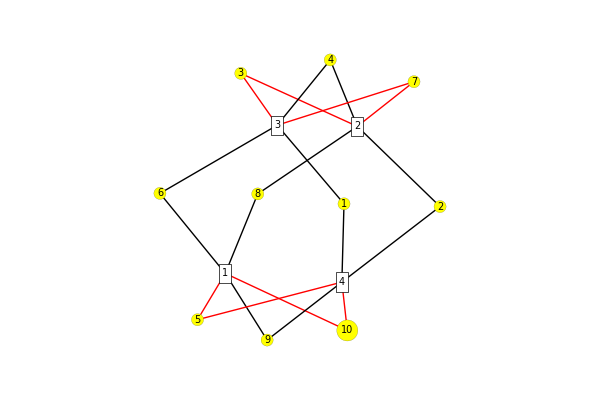

In [10]:
plot(lm.fg, highlighted_edges=op, randseed=randseed)

Flip the corresponding variables (__Warning__: do not run this cell twice otherwise the flip will cancel)

In [11]:
# Retrieve indices of variables to flip
to_flip = unique!([tup[2] for tup in op])
# Flip them in `lm.x` which is the internal state where the current solution guess is stored
lm.x[to_flip] .⊻= 1

4-element view(::Array{Int64,1}, [5, 10, 3, 7]) with eltype Int64:
 1
 1
 1
 1

Compute the distortion again

In [12]:
d2 = distortion(lm)
println("Distortion after flipping: ", d2)

Distortion after flipping: 0.2


Distortion decreased!

Try improving again

In [13]:
H = weighted_full_adjmat(lm)
op_, w = optimal_cycle(H)

([(1, 12), (1, 13), (2, 6), (2, 12), (4, 6), (4, 13)], -2.004164442260925)

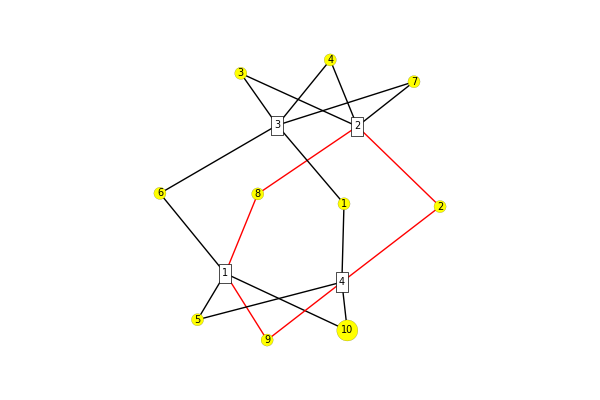

In [14]:
op = variables_from_cycle(op_, m)
plot(lm.fg, highlighted_edges=op, randseed=randseed)

In [15]:
to_flip = unique!([tup[2] for tup in op])
lm.x[to_flip] .⊻= 1
d3 = distortion(lm)
println("Distortion after flipping: ", d3)

Distortion after flipping: 0.1


Decreased again!

Try one last time

In [16]:
H = weighted_full_adjmat(lm)
op_, w = optimal_cycle(H)

(Tuple{Int64,Int64}[], 0.0)

Solution is already optimal. Print it and compare it with the one obtained by exhaustive enumeration

In [17]:
x_cycles = lm.x

lm2 = deepcopy(lm)
solve!(lm2, ExhaustEnum())
x_exact = lm2.x
[x_cycles x_exact]

10×2 Array{Int64,2}:
 0  0
 1  1
 1  1
 0  0
 1  1
 0  0
 1  1
 1  1
 1  1
 1  1

Yes!

# On a larger instance

In [28]:
function one_loop_flip(lm::LossyModel)
    H = weighted_full_adjmat(lm)
    op_, w = optimal_cycle(H)
    op = variables_from_cycle(op_, lm.fg.m)
    to_flip = unique!([tup[2] for tup in op])
    lm.x[to_flip] .⊻= 1
    return op, to_flip, w
end

one_loop_flip (generic function with 1 method)

In [29]:
n = 1000
m = 500
lm = LossyModel(2,n,m,randseed=randseed)
lm_copy = deepcopy(lm)

Lossy compression model:
 - Factor Graph with n=1000 variables and m=500 factors defined on GF(2)
 - Inverse temperatures β₁=Inf for checks and β₂=1.0 for overlap


In [30]:
dist = Float64[]
finished = false
maxiter = 20
cnt = 0
weights_ = Float64[]
flipped_history = Vector{Int}[]
while !finished && cnt!=maxiter
    op, to_flip, w = one_loop_flip(lm)
    push!(flipped_history, to_flip)
    push!(weights_, w)
    push!(dist, distortion(lm))
    finished = isempty(op)
    cnt += 1
end
println("Finished")
dist_cycles = distortion(lm)

Finished


0.145

In [37]:
# Store the history of which variables have been flipped and their corresponding energy contribution
flipped_en = zeros(length(flipped_history))
for i in eachindex(flipped_history)
    # Convert indices of variables to flip -> 1 at positions where to flip
#     flipped_int = zeros(Int, lm.fg.n)
#     flipped_int[flipped_history[i]] .= 1
#     flipped_en[i] = energy(lm, flipped_int)
    flipped_en[i] = hd(ones(Int,length(flipped_history[i])), lm.y[flipped_history[i]])
end

At each step, print:
- The distortion of the configuration after having flipped the cycle(s)
- The weight of the optimal cycle 
- $\Delta E$: The overlap energy computed only on the flipped variables

In [40]:
[dist weights_ flipped_en]

20×3 Array{Float64,2}:
 0.189  -632.0          50.0
 0.146   -86.0002       95.0
 0.145    -2.00021      41.0
 0.145    -0.000340581  51.0
 0.145    -0.000202161  44.0
 0.145    -0.000114045  32.0
 0.145    -0.000199361  41.0
 0.145    -0.000187138  34.0
 0.145    -0.000175114  29.0
 0.145    -0.000282518  28.0
 0.145    -0.000221497  40.0
 0.145    -0.000257651  27.0
 0.145    -0.000335601  54.0
 0.145    -0.000220778  24.0
 0.145    -0.000114426  15.0
 0.145    -0.000114112  35.0
 0.145    -0.000265287  44.0
 0.145    -0.000128789  48.0
 0.145    -0.0001086    50.0
 0.145    -0.000351227  40.0

### Plot

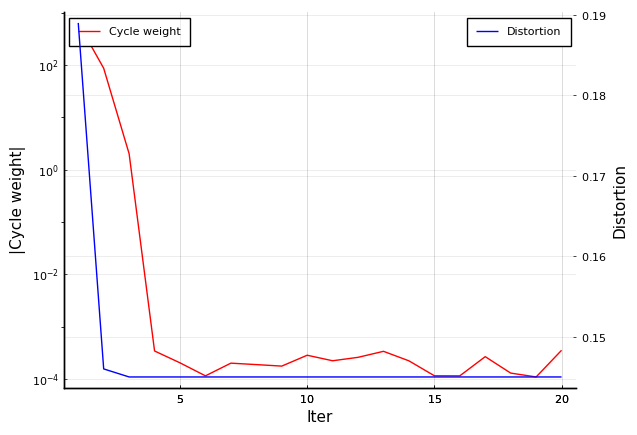

In [34]:
plot(abs.(weights_), ylabel="|Cycle weight|", color=:red, label="Cycle weight", legend=:topleft, yscale=:log10)
right_axis = twinx()
plot!(right_axis, dist, xlabel="Iter", ylabel="Distortion", color=:blue, label="Distortion", legend=:topright)
gui()

Compare with MS

In [415]:
ms = MS(maxiter=200)
res = solve!(lm_copy, ms)
dist_ms = distortion(lm_copy)

0.145